# An interactive introduction to polyphase filterbanks

**Author:** Danny Price, UC Berkeley

**License:** [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/)

In [1]:
%matplotlib inline

In [2]:
# Import required modules
import numpy as np
import scipy
from scipy.signal import firwin, freqz, lfilter
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")

def db(x):
    """ Convert linear value to dB value """
    return 10*np.log10(x)

## Introduction

If you've opened up this notebook, you're probably trying to learn about polyphase filterbanks and/or spectrometers and found it all a bit confusing. 

This notebook is here to help. 

To get the most out of this notebook, you should supplement it with a more rigorous overview of the PFB and spectrometers. I've written up a [chapter on spectrometers in radio astronomy](http://arxiv.org/abs/1607.03579) which can serve as your noble steed. There is quite a bit of background knowledge about digital signal processing (DSP) that I'm not going to present -- head on over to the free [DSP Guide](http://www.dspguide.com/ch1.htm) by Stephen Smith if you need a refresher. 

## What is a PFB?

A polyphase filterbank (PFB) is simply an efficient computational structure used to form a bank of filters. All that is required to form a PFB is to place a "prototype polyphase filter structure" in front of an FFT. The frontend enhances the filter response of the FFT, making it better by using time samples and filter coefficients.

That's it. For more information, have a read of [this chapter](http://arxiv.org/abs/1607.03579). As a first call though, let's look at polyphase decomposition, and how to do it using `Numpy`.

## Polyphase decomposition

Polyphase decomposition is at the heart of the PFB technique, and is just decomposing a signal $x(n)$ into multiple 'phases' or 'branches'. For example, even and odd decomposition is just:

$$\begin{eqnarray}
x_{even}(n') & = & \left\{ x(0),x(2),x(4),...\right\} \\
x_{odd}(n') & = & \left\{ x(1),x(3),x(5),...\right\} .
\end{eqnarray}$$

More generally, we can decompose $x(n)$ into $P$ phases, denoted $x_p(n')$. Below is a simple example of polyphase decomposition using numpy:

In [3]:
x = np.array([1,2,3,4,5,6,7,8,9,10])
P = 5

x_p = x.reshape((len(x)//P, P)).T
print (x_p)

[[ 1  6]
 [ 2  7]
 [ 3  8]
 [ 4  9]
 [ 5 10]]


### The PFB frontend

Next, let's have a look at the polyphase frontend. This sounds fancy but isn't all that complicated. The purpose of the PFB frontend is to convert your set of $P$ polyphase branches $x_p(n')$ into a set of subfiltered signals, $y_p(n')$

$$
\begin{equation}
y_{p}(n')=\sum_{m=0}^{M-1}h_{p}(m)x_{p}(n'-m),
\end{equation}
$$

where $h_p$ are filter coefficients that have been divided between the $P$ branches.

Here is a diagram showing the operations performed by the frontend, for $M=3$ taps:

![pfb_chart](diagrams/pfb_chart.png)

The diagram shows an input signal being divided into $M$ taps, each with $P$ points. Within each tap, the signal is  multiplied by the filter coefficients, then a sum across taps is performed. After this, another $P$ points are read, and the signals propagate left-to-right into the next tap (following the arrows).

Not 100% sure you really understand that diagram? Well, let's try and code it up, and hopefully get a better handle on what's happening. Here's a simple implementation:

In [4]:
def pfb_fir_frontend(x, win_coeffs, M, P):
    W = int(x.shape[0] / M / P)
    x_p = x.reshape((W*M, P)).T
    h_p = win_coeffs.reshape((M, P)).T
    x_summed = np.zeros((P, M * W - M))
    for t in range(0, M*W-M):
        x_weighted = x_p[:, t:t+M] * h_p
        x_summed[:, t] = x_weighted.sum(axis=1)
    return x_summed.T

Wow. Only 9 lines required! This is short enough for us to go through line by line:

1. Function declaration. The frontend reads in:
  * an input signal x (a numpy array). For this simple code, x has to be a multiple of $M*P$
  * some window coefficients, 
  * an integer M representing the number of taps
  * an integer P representing the number of branches
2. Compute the number of windows of length $P$ there are in the data.
3. We apply polyphase decomposition on $x(n)$ to get a set of branches $x_p(n')$.
4. We also divide the window coefficients into branches.
6. Instantiate an empty array to store the signal $y_p(n')$. This is a little shorter than the original $x_p(n')$ as it takes a few cycles for the taps to fill up with data.
7. Now we start a loop, so we can multiply through each time step by the filter coefficients. 
8. This is the magic line. we take $M$ samples from each branch, $x_p(n')$, and multiply it through by the filter coefficients. We need to march through the entire `x_p` array, hence the loop.
9. Now we sum over taps.
10. Return the data, with a transpose so that axes are returned as (time, branch).

Let's apply this to some example data. To do that, we'll need a function to generate window coefficients. Fortunately, this is built in to `scipy`. We can make a simple function to generate a `sinc` of the right length and multiply it through by the window of our choice:

In [5]:
def generate_win_coeffs(M, P, window_fn="hamming"):
    win_coeffs = scipy.signal.get_window(window_fn, M*P)
    sinc       = scipy.signal.firwin(M * P, cutoff=1.0/P, window="rectangular")
    win_coeffs *= sinc
    return win_coeffs

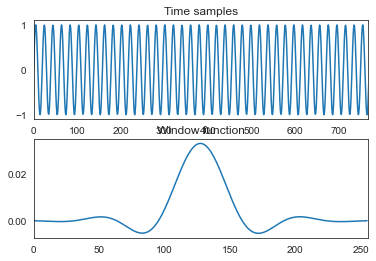

In [6]:
M = 8
P = 32

x = np.sin(np.arange(0, M*P*10) / np.pi)
win_coeffs = generate_win_coeffs(M, P, window_fn="hamming")

plt.subplot(2,1,1)
plt.title("Time samples")
plt.plot(x)
plt.xlim(0, M*P*3)

plt.subplot(2,1,2)
plt.title("Window function")
plt.plot(win_coeffs)
plt.xlim(0, M*P)
plt.show()

Now we are ready to try applying `pfb_fir_frontend` to our data:

In [7]:
y_p = pfb_fir_frontend(x, win_coeffs, M, P)

print("n_taps: %i" % M)
print("n_branches: %i" % P)
print("Input signal shape: %i" % x.shape)
print("Window shape:       %i" % win_coeffs.shape)
print("Output data shape: %s" % str(y_p.shape))

n_taps: 8
n_branches: 32
Input signal shape: 2560
Window shape:       256
Output data shape: (72, 32)


And we can plot the output `y_p` using `imshow`:

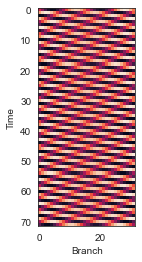

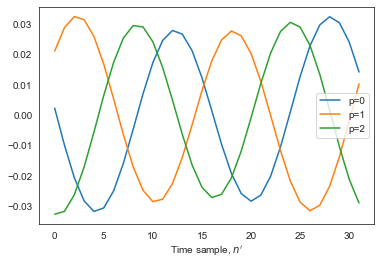

In [8]:
plt.figure()
plt.imshow(y_p)
plt.xlabel("Branch")
plt.ylabel("Time")

plt.figure()
plt.plot(y_p[0], label="p=0")
plt.plot(y_p[1], label="p=1")
plt.plot(y_p[2], label="p=2")
plt.xlabel("Time sample, $n'$")
plt.legend()
plt.show()

Don't spend too much time trying to interpret this! The frontend only becomes interesting when you follow it up with an FFT.

## Polyphase filterbank

now we have an PFB frontend, all we need is to add on an FFT. Here is the code to implement a simple PFB in python:

In [9]:
def fft(x_p, P, axis=1):
    return np.fft.rfft(x_p, P, axis=axis)

def pfb_filterbank(x, win_coeffs, M, P):
    x_fir = pfb_fir_frontend(x, win_coeffs, M, P)
    x_pfb = fft(x_fir, P)
    return x_pfb

The first function is just a helper, and uses the in-built `numpy.fft` library. We apply the FFT over a given axis, which in this case is branches (the number of branches == length of FFT).

The actual `pfb_filterbank` function is now just two lines long: apply a `pfb_fir_frontend` to the data, and then apply an `fft` to the output. The final step is taking the output of the `pfb_filterbank`, squaring it, and taking an average over time. 

Finally, here's a function that implements a spectrometer:

In [10]:
def pfb_spectrometer(x, n_taps, n_chan, n_int, window_fn="hamming"):
    M = n_taps
    P = n_chan
    
    # Generate window coefficients
    win_coeffs = generate_win_coeffs(M, P, window_fn)

    # Apply frontend, take FFT, then take power (i.e. square)
    x_fir = pfb_fir_frontend(x, win_coeffs, M, P)
    x_pfb = fft(x_fir, P)
    x_psd = np.abs(x_pfb)**2
    
    # Trim array so we can do time integration
    x_psd = x_psd[:np.round(x_psd.shape[0]//n_int)*n_int]
    
    # Integrate over time, by reshaping and summing over axis (efficient)
    x_psd = x_psd.reshape(x_psd.shape[0]//n_int, n_int, x_psd.shape[1])
    x_psd = x_psd.mean(axis=1)
    
    return x_psd

Let's try it out by generating some data

In [11]:
M     = 4          # Number of taps
P     = 1024       # Number of 'branches', also fft length
W     = 1000       # Number of windows of length M*P in input time stream
n_int = 2          # Number of time integrations on output data

# Generate a test data steam
samples = np.arange(M*P*W)
noise   = np.random.random(M*P*W) 
freq = 1
amp  = 0.02
cw_signal = amp * np.sin(samples * freq)
data = noise + cw_signal

Which we can have a quick look at first:

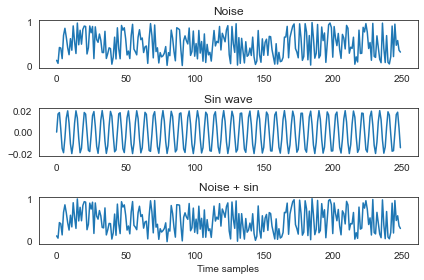

In [12]:
plt.subplot(3,1,1)
plt.title("Noise")
plt.plot(noise[:250])
plt.subplot(3,1,2)
plt.title("Sin wave")
plt.plot(cw_signal[:250])
plt.subplot(3,1,3)
plt.title("Noise + sin")
plt.plot(data[:250])
plt.xlabel("Time samples")
plt.tight_layout()
plt.show()

Now, let's compute the spectrum and plot it over frequency vs. time using `imshow`

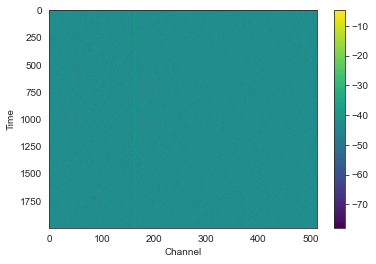

In [13]:
X_psd = pfb_spectrometer(data, n_taps=M, n_chan=P, n_int=2, window_fn="hamming")

plt.imshow(db(X_psd), cmap='viridis', aspect='auto')
plt.colorbar()
plt.xlabel("Channel")
plt.ylabel("Time")
plt.show()

This plot over frequency vs. time is known as a *waterfall plot*. At the moment, we can't see the sin wave we put in there. If we integrate longer, the noise integrates down as $\sqrt{t}$ (see the radiometer equation), whereas the sin wave is coherent. Using a longer time integration:

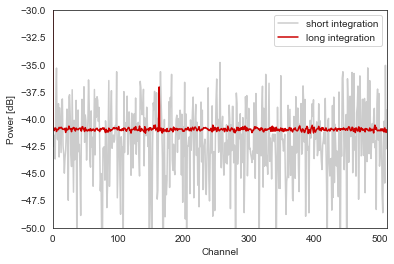

In [14]:
X_psd2 = pfb_spectrometer(data, n_taps=M, n_chan=P, n_int=1000, window_fn="hamming")

plt.plot(db(X_psd[0]), c='#cccccc', label='short integration')
plt.plot(db(X_psd2[1]), c='#cc0000', label='long integration')
plt.ylim(-50, -30)
plt.xlim(0, P/2)
plt.xlabel("Channel")
plt.ylabel("Power [dB]")
plt.legend()
plt.show()

### Testing leakage with sin waves

Is the PFB's spectral leakage as good as people claim? We can test this out by sweeping a sine wave input and looking at the response of a few channels as a function of sine wave period.

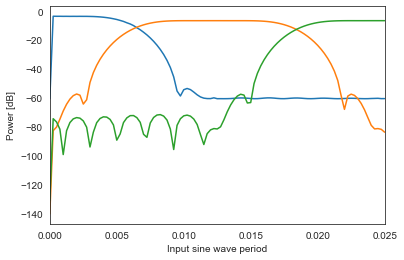

In [15]:
M, P, W = 6, 512, 256                   # taps, channels, windows
period = np.linspace(0, 0.025, 101)

chan0_val = []
chan1_val = []
chan2_val = []
for p in period:
    t = np.arange(0, M*P*W)
    x = np.sin(t * p) + 0.001
    X_psd = pfb_spectrometer(x, n_taps=M, n_chan=P, n_int=256, window_fn="hamming")
    chan0_val.append(X_psd[0, 0])
    chan1_val.append(X_psd[0, 1])
    chan2_val.append(X_psd[0, 2])
    
    
plt.plot(period, db(chan0_val))
plt.plot(period, db(chan1_val))
plt.plot(period, db(chan2_val))
plt.xlim(period[0], period[-1])
plt.ylabel("Power [dB]")
plt.xlabel("Input sine wave period")
plt.show()

## Where to go from here

The PFB code in this notebook is quite simple, with no bells and whistles. As an exercise, you could:
* add some error handling (e.g. what happens when the time stream isn't a multiple of $M\times P$?), 
* make it read from a file and output to another file 
* make it work on datasets larger than your computer's memory
* Implement some more fancy features like oversampling
* Implement an inverse PFB
* port it to Julia, Cythonize it, put it in a docker container, print out a figure and stick it on your macbook.
* etcetera. 

If you do something that you think would make a great example, please push it to this github repository!

### Open source codes
Are you about to build a new instrument that needs a PFB spectrometer? The good news is that you probably don't have to write your own highly efficient PFB implementation, because people have done it for you. Here's a selection of codes:

* The [CASPER](https://casper.berkeley.edu/wiki/Getting_Started) collaboration provide a FPGA-based PFB and a design environment for making FPGA-based instruments for radio astronomy.
* Karel Adámek, Jan Novotný and Wes Armour wrote very efficient PFB codes for CPU, GPU and Intel Phi, available on [github](https://github.com/wesarmour/astro-accelerate) and detailed in [arXiv](http://arxiv.org/abs/1511.03599)
* Jayanth Chennamangalam created a PFB GPU code, which is used in the [VEGAS spectrometer](http://www.gb.nrao.edu/vegas/). It is available on [github](https://github.com/jayanthc/grating/) and detailed on [arXiv](http://arxiv.org/abs/1411.0436).

### Citing

If you find this notebook useful, please consider referencing the accompanying chapter in your thesis / paper / postcard / sticky note:

Danny C. Price, *Spectrometers and Polyphase Filterbanks in Radio Astronomy*, 2016. Available online at: http://arxiv.org/abs/1607.03579
